In [54]:
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve



In [7]:
import splitfolders
import shutil
import os
from PIL import Image
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
from sklearn.metrics import classification_report
from tensorflow import keras


global augmented
augmented = False

Build Train/Test/Validation datasets from the given dataset.

In [8]:
def build_directory_dict(root_dir):
    directory_dict = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath != root_dir:
            parent_dir = os.path.basename(dirpath)
            if parent_dir not in directory_dict:
                directory_dict[parent_dir] = []
            for dirname in dirnames:
                directory_dict[parent_dir].append(dirname)

    # check if values for any key is empty then remove that key value pair from dict
    dict_copy = directory_dict.copy()
    print(dict_copy)
    for key, value in dict_copy.items():
        if not value:
            del directory_dict[key]
    return directory_dict

In [9]:
def copy_data_to_dest(source, dest, class_labels, split_ratios):

    for shape, types in class_labels.items():
        src = source + '/' + shape
        temp_dir = source + '/temp/' + shape

        if (os.path.exists(temp_dir)):
            shutil.rmtree(temp_dir) 

        splitfolders.ratio(src, output=temp_dir, ratio=split_ratios, seed=1337)
      
        for type_val in types:
            shutil.move(temp_dir + '/train/' + type_val, dest + '/train/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/test/'  + type_val, dest + '/test/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/val/'   + type_val, dest + '/val/' + shape + '/' + type_val)
        
    shutil.rmtree(r'./Dataset/trafficsigns_dataset/temp')

In [10]:
# use split folders to split the dataset into train, test and validation datasets
def create_train_test_val(split_ratios, src, dest):
    if (os.path.exists(dest)):
        shutil.rmtree(r'./Dataset/train_test_val') 
    splitfolders.ratio(src, output=dest, seed=1337, ratio=split_ratios)
    class_labels = build_directory_dict(src)
    copy_data_to_dest(src, dest, class_labels, split_ratios)
    
    

In [11]:
create_train_test_val(split_ratios=(0.6, 0.2, 0.2), src='Dataset/trafficsigns_dataset', dest='Dataset/train_test_val')  

Copying files: 0 files [00:00, ? files/s]


{'diamond': ['rightofway'], 'rightofway': [], 'hex': ['stop'], 'stop': [], 'square': ['laneend', 'parking', 'continue', 'crossing'], 'laneend': [], 'parking': [], 'continue': [], 'crossing': [], 'triangle': ['giveway', 'warning'], 'giveway': [], 'warning': [], 'round': ['traveldirection', 'limitedtraffic', 'speed', 'roundabout', 'noentry', 'noparking', 'bicycle', 'trafficdirective'], 'traveldirection': [], 'limitedtraffic': [], 'speed': [], 'roundabout': [], 'noentry': [], 'noparking': [], 'bicycle': [], 'trafficdirective': []}


Copying files: 282 files [00:00, 4535.88 files/s]
Copying files: 43 files [00:00, 4470.76 files/s]
Copying files: 688 files [00:00, 5008.19 files/s]
Copying files: 926 files [00:00, 2658.18 files/s]
Copying files: 1760 files [00:00, 3972.08 files/s]


Fetch the images from the folder and build a dataframe

In [12]:
def build_df_from_image_list(image_list):
    df = pd.DataFrame(image_list, columns = ['Path', 'Shape', 'Type'])
    return df

In [13]:
def fetch_images(root_path):
    image_list = []
    for filepath in glob.glob(root_path, recursive=True): #assuming gif
      shape = filepath.split('/')[3]
      types = filepath.split('/')[4]
      image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [14]:
train = fetch_images('Dataset/train_test_val/train/*/*/*.png')
test = fetch_images('Dataset/train_test_val/test/*/*/*.png')
val = fetch_images('Dataset/train_test_val/val/*/*/*.png')

In [15]:
val.head()

,Path,Shape,Type
0,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
1,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
2,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
3,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
4,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway


In [16]:
def print_data_info(train, test, val, key='Shape'):
    print("########################## Shape ##########################")
    print(f" Train: {train.shape}, Test: {test.shape}, Val: {val.shape}\n",)
    print("########################## Unique ##########################")
    print("Total Classes: ", len(train[key].unique()))
    print(f" Train: {train[key].unique()}, \nTest: {test[key].unique()}, \nVal: {val[key].unique()}\n")
    print("########################## Count ##########################")
    print(f" Train: {train[key].value_counts()}, Test: {test[key].value_counts()}, Val: {val[key].value_counts()}\n")


In [17]:
print_data_info(train, test, val, key='Shape')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  5
 Train: ['diamond' 'hex' 'square' 'triangle' 'round'], 
Test: ['diamond' 'hex' 'square' 'triangle' 'round'], 
Val: ['diamond' 'hex' 'square' 'triangle' 'round']

########################## Count ##########################
 Train: Shape
round       1054
triangle     555
square       411
diamond      169
hex           25
Name: count, dtype: int64, Test: Shape
round       356
triangle    186
square      141
diamond      57
hex          10
Name: count, dtype: int64, Val: Shape
round       350
triangle    185
square      136
diamond      56
hex           8
Name: count, dtype: int64



In [18]:
print_data_info(train, test, val, key='Type')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  16
 Train: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective'], 
Test: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective'], 
Val: ['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective']

########################## Count ##########################
 Train: Type
warning             417
noentry             225
speed               189
bicycle             171
rightofway          169
parking       

Visualise Data

In [19]:
def visualise_data(df):
    # plot distribution of each class
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    # Plot distribution of each class within shape
    sns.countplot(data=df, x='Shape', ax=axs[0])
    axs[0].set_title('Distribution of Shapes')

    # Plot distribution of each class within type
    sns.countplot(data=df, y='Type', ax=axs[1])
    axs[1].set_title('Distribution of Types')

    plt.tight_layout()
    plt.show()

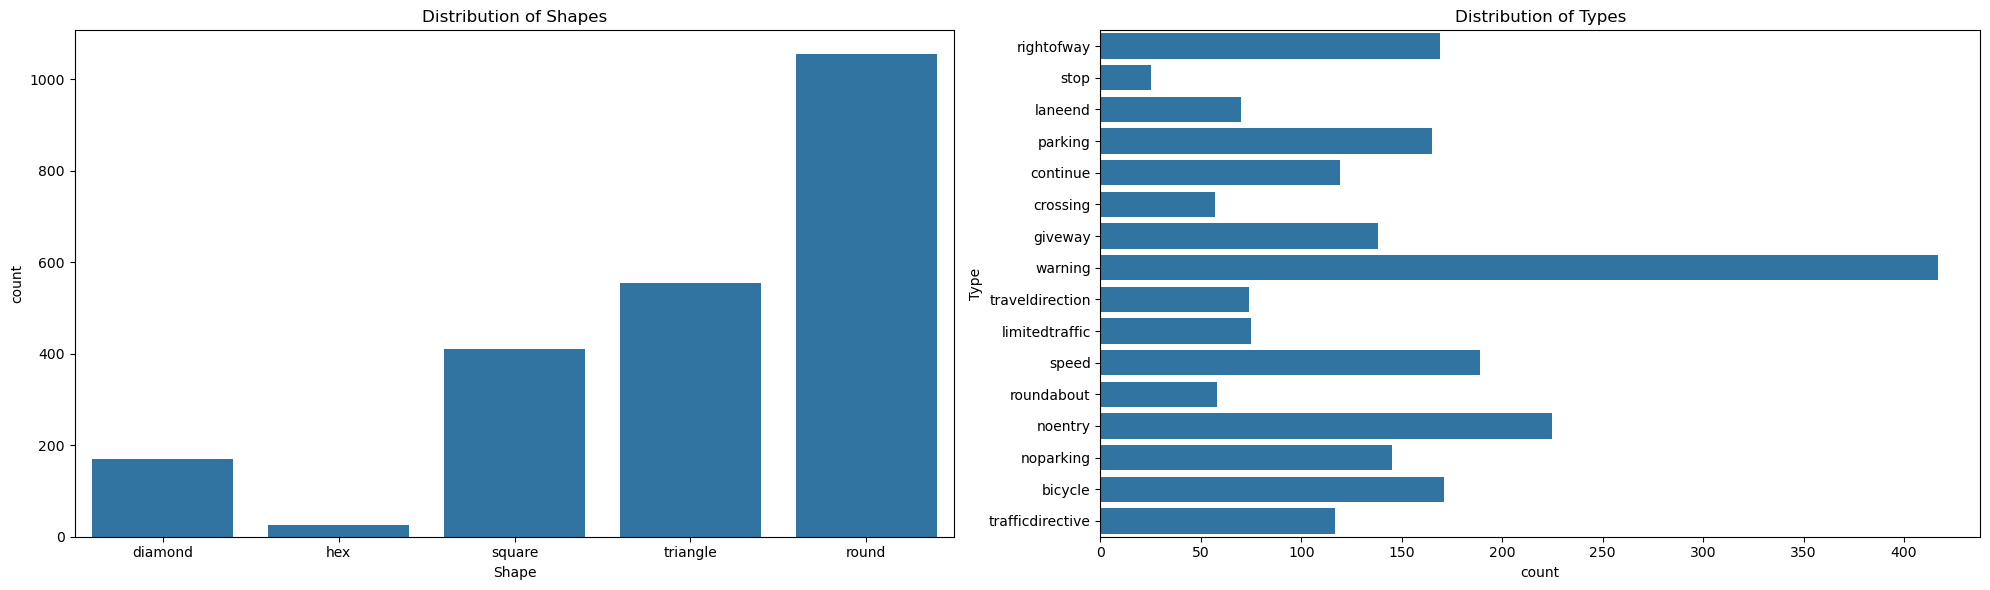

In [20]:
visualise_data(train)

In [21]:
# Iterate through each image path in the DataFrame
def check_image_dimensions(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        flag = False

        # Open the image using PIL
        with Image.open(image_path) as img:
            width, height = img.size
            # Check if dimensions are not 28x28
            if width != 28 or height != 28:
                flag = True
                print(f"Image at path {image_path} has dimensions {width}x{height}")

    if not flag:
        return "All images have dimensions 28x28"

In [22]:
print(f"Train: {check_image_dimensions(train)}\n Test: {check_image_dimensions(test)}\n Val: {check_image_dimensions(val)}")    

Train: All images have dimensions 28x28
 Test: All images have dimensions 28x28
 Val: All images have dimensions 28x28


Display images

In [73]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [150, 150])  
    return image

In [74]:
def display_images(data, column, num_images):
    categories = data[column].unique()  # Get unique categories in the specified column
    
    for cat in categories:
        # Filter data for the current category
        category_data = data[data[column] == cat]
        
        # Sample a subset of images for display (up to num_images)
        sample_paths = category_data['Path'].sample(min(num_images, len(category_data))).values
        
        # Display images for the current category
        plt.figure(figsize=(15, 2))
        plt.suptitle(f'{column}: {cat}', fontsize=10)
        for i, image_path in enumerate(sample_paths):
            image = load_image(image_path).numpy().astype("uint8")
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            # plt.title(cat)
            plt.axis("off")
        plt.show()


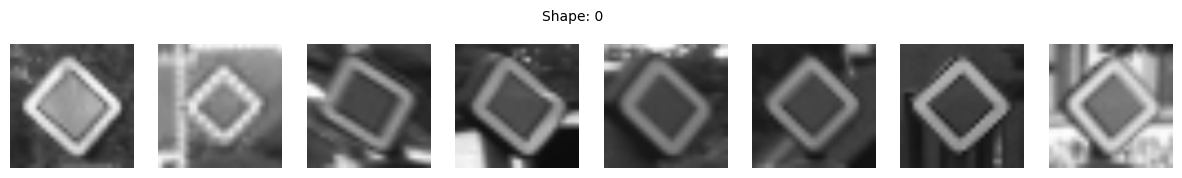

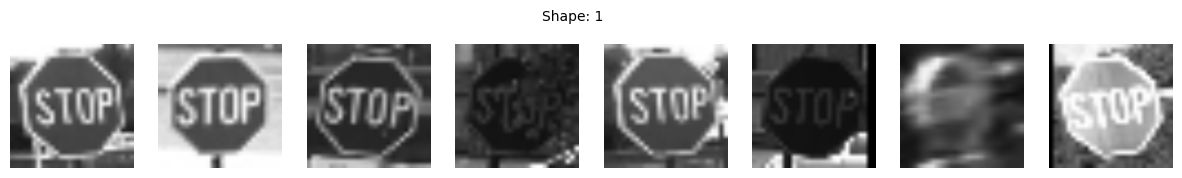

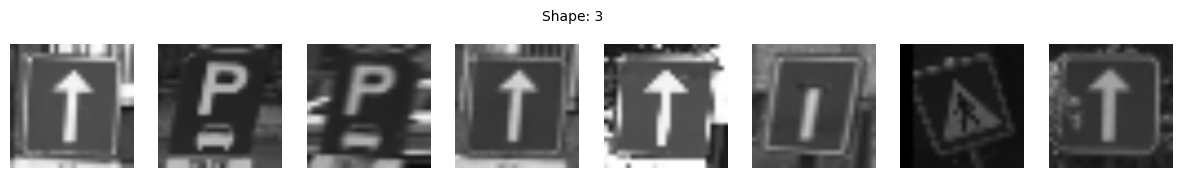

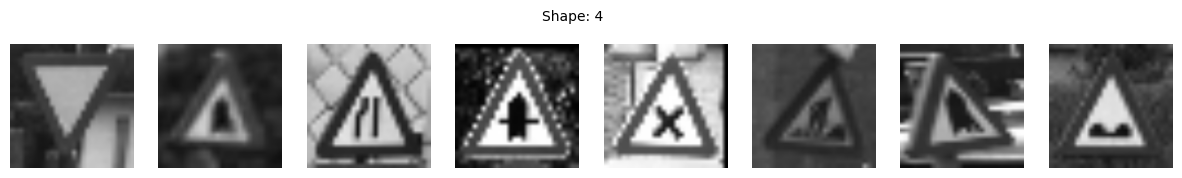

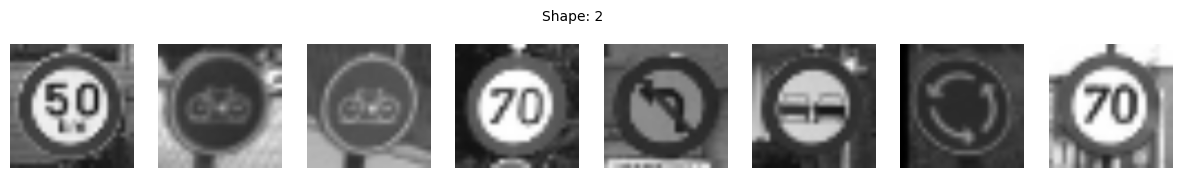

In [75]:
display_images(train, "Shape", 8)

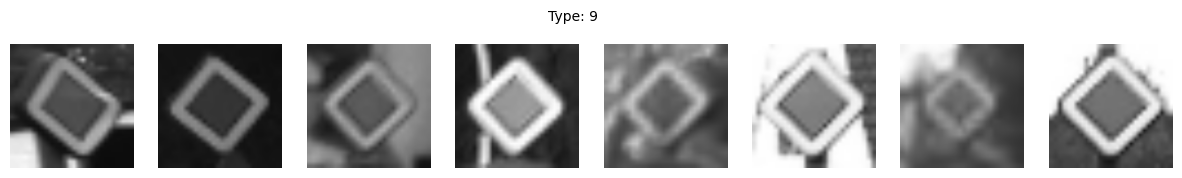

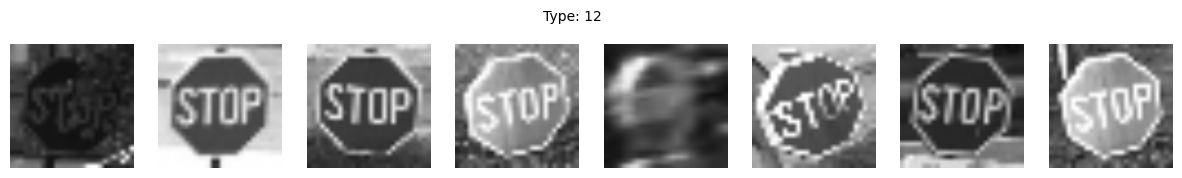

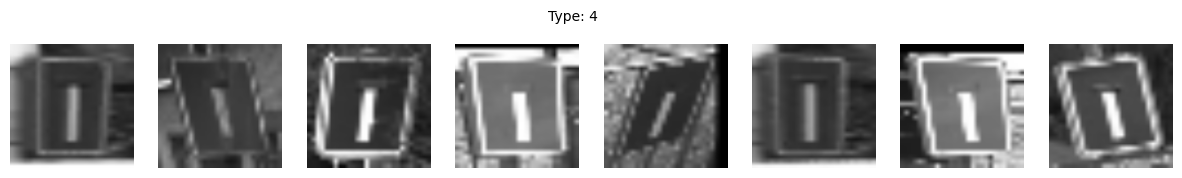

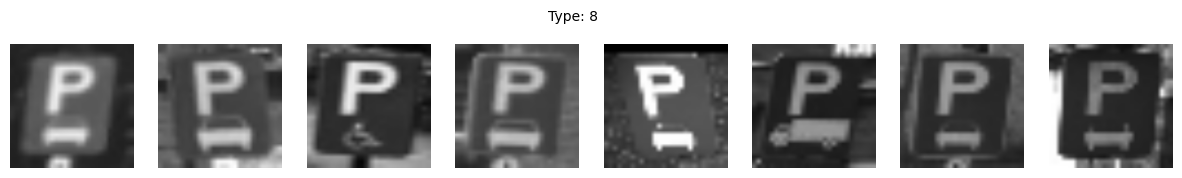

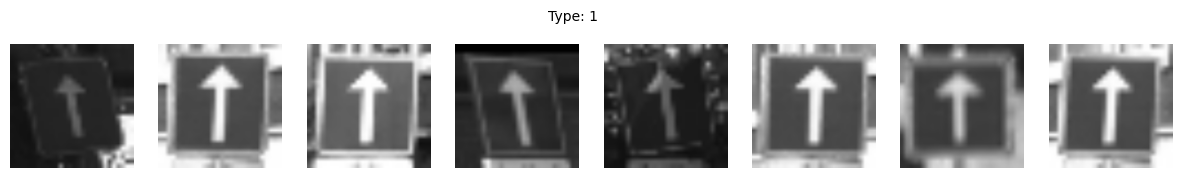

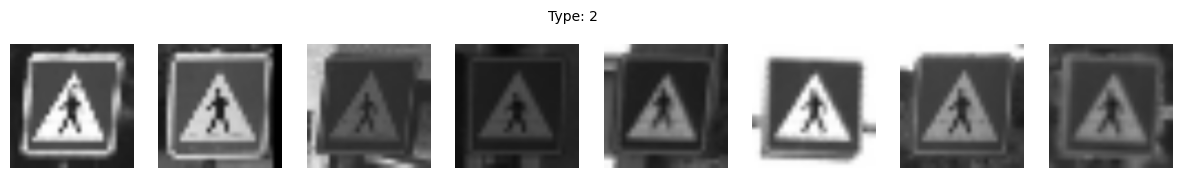

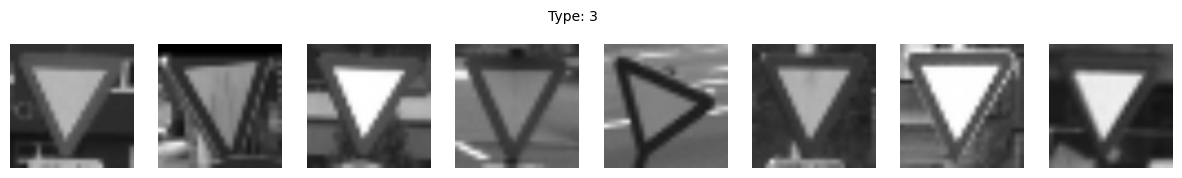

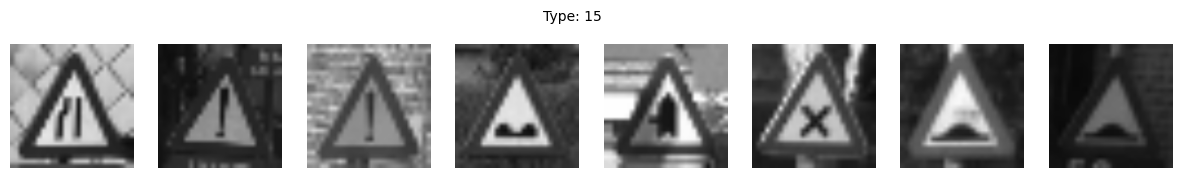

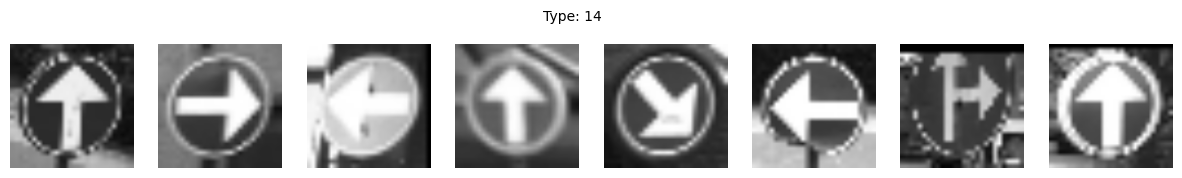

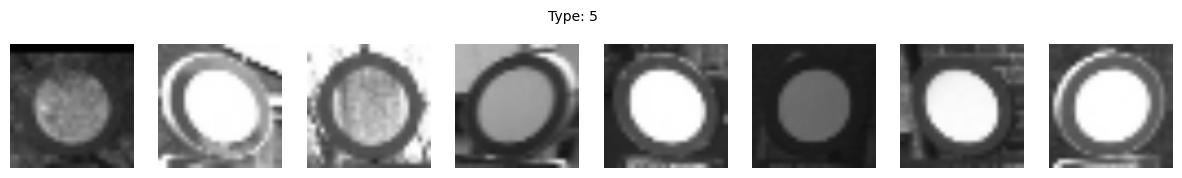

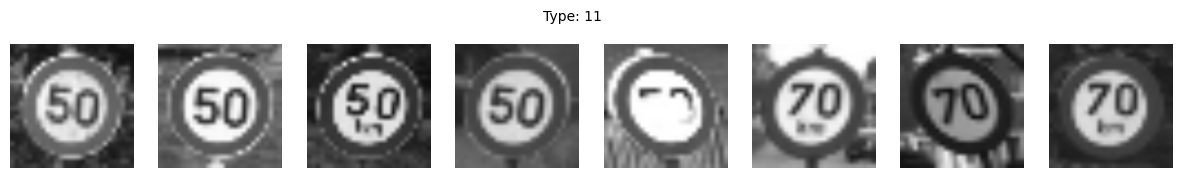

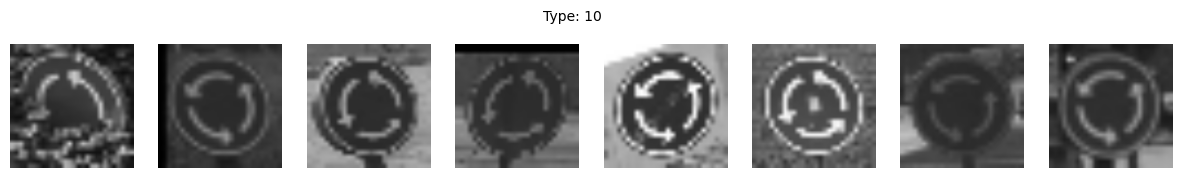

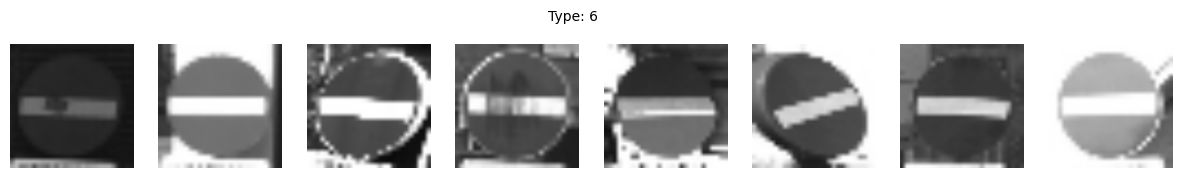

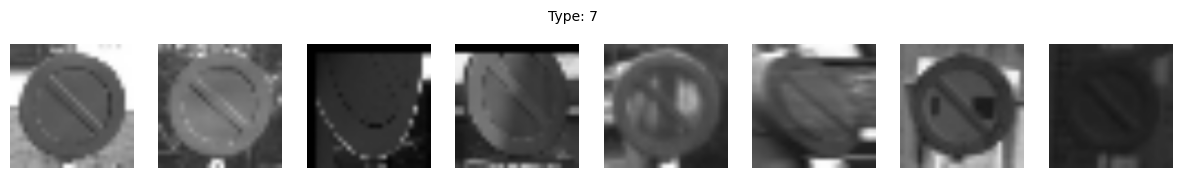

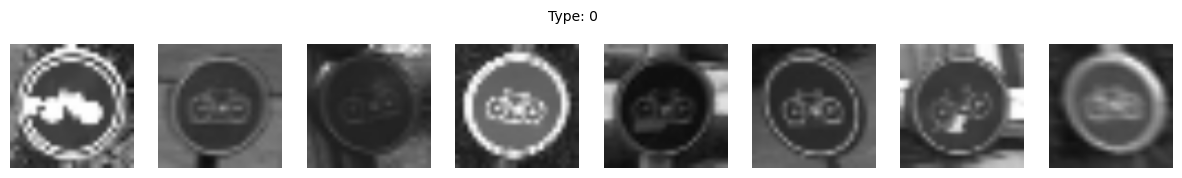

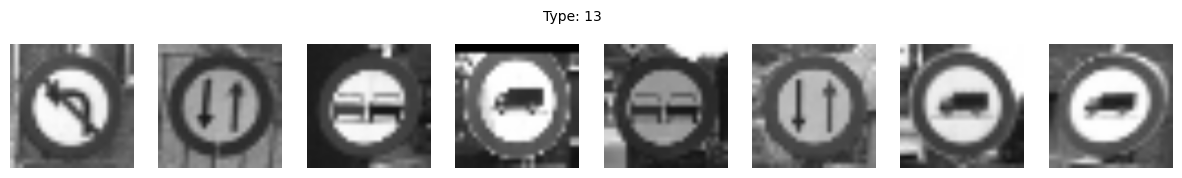

In [76]:
display_images(train, "Type", 8)

Encode class labels

In [23]:
def encoder(df):
    label_encoder = LabelEncoder()
    df['Shape'] = label_encoder.fit_transform(df['Shape'])
    df['Type'] = label_encoder.fit_transform(df['Type'])

    return df    

In [24]:
encoder(train)
encoder(test)
encoder(val)
train.head()

,Path,Shape,Type
0,Dataset/train_test_val/train/diamond/rightofwa...,0,9
1,Dataset/train_test_val/train/diamond/rightofwa...,0,9
2,Dataset/train_test_val/train/diamond/rightofwa...,0,9
3,Dataset/train_test_val/train/diamond/rightofwa...,0,9
4,Dataset/train_test_val/train/diamond/rightofwa...,0,9


Handle Data Imbalance

In [25]:
def augment_data(df, image_batch_size, dest):
    
    images = []
    for image_path in df['Path']:
        img = plt.imread(image_path)
        images.append(img_to_array(img))
      

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
    )

    for img in images:
        img = img.reshape((1,) + img.shape)
        for j, _ in enumerate(datagen.flow(img, save_to_dir=dest, batch_size=1, save_prefix='aug', save_format='png')):
            if j >= image_batch_size:
                break


In [26]:
def make_dir(src, dest):
    if (os.path.exists(dest)):
        if dest == 'Dataset/shape_aug/train':
            shutil.rmtree(r'./Dataset/shape_aug/train')
        elif dest == 'Dataset/type_aug/train':
            shutil.rmtree(r'./Dataset/type_aug/train')
    
    shutil.copytree(src, dest)

In [27]:
def start_shape_augmentation(train, choice, src, dest, batch_dict):
    make_dir(src=src, dest=dest)
    
    for key, [index, value, shape] in batch_dict.items():
        path = dest + '/' + shape + '/' + key
        augment_data(df=train[train.Type == index], image_batch_size=value, dest=path) 
    
    train_aug = fetch_images(dest + '/*/*/*.png')
    train_aug = encoder(train_aug)
    print(train_aug[choice].value_counts())
    visualise_data(train_aug)
    return train_aug

Shape
2    1054
1    1013
3     908
4     827
0     824
Name: count, dtype: int64


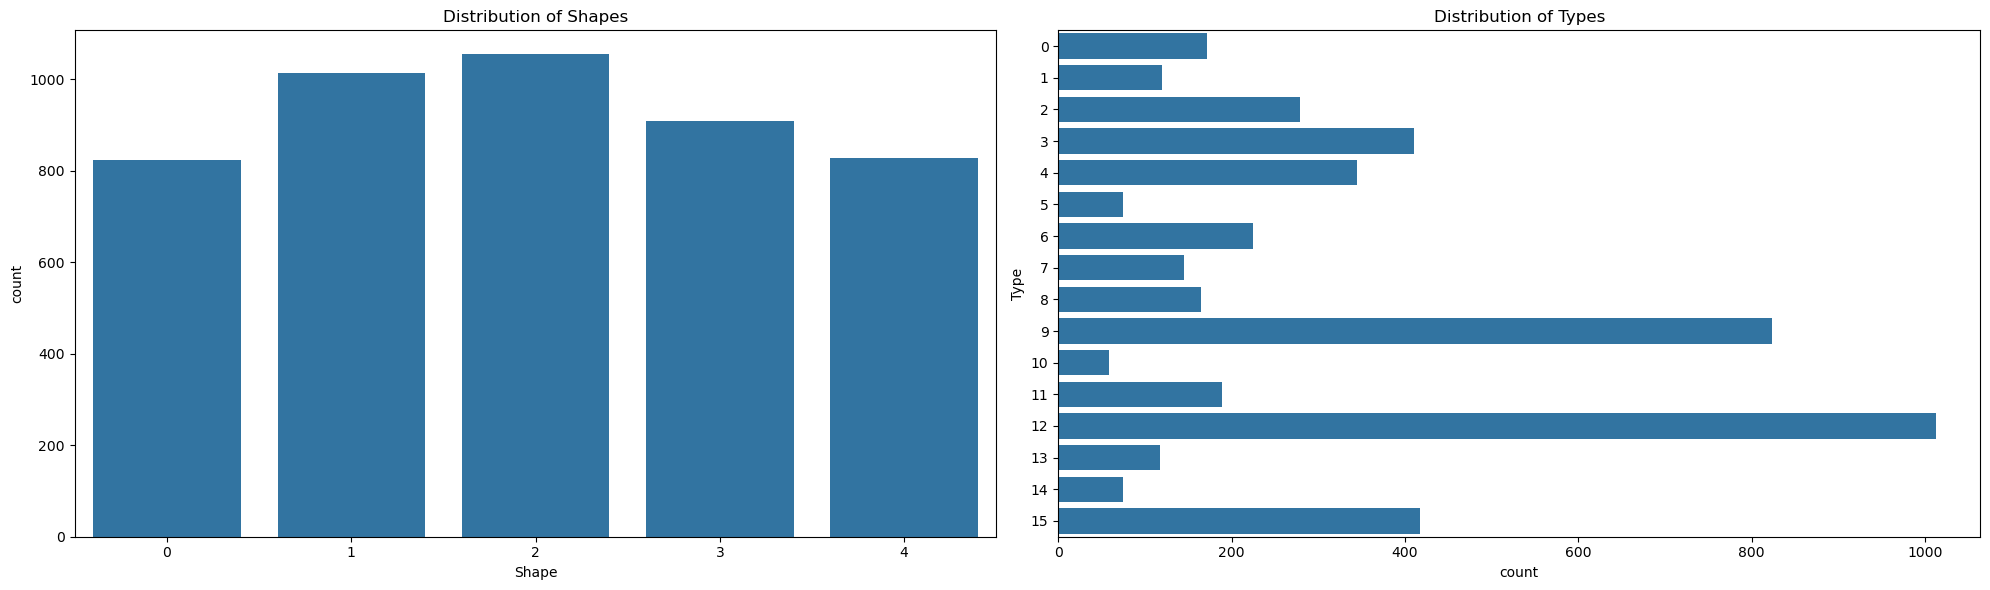

In [28]:
batch_dict_shape = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 41, 'hex'],
        'giveway': [3, 1, 'triangle'],
        'crossing': [2, 3, 'square'],
        'laneend': [4, 3, 'square'],
        'rightofway': [9, 3, 'diamond'],
    }
train_shape_aug = start_shape_augmentation(train, 'Shape', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/shape_aug/train', 
                                           batch_dict=batch_dict_shape)

Type
6     663
7     570
13    565
11    558
3     546
5     511
2     506
0     505
14    503
9     502
8     489
4     476
1     470
10    456
12    440
15    417
Name: count, dtype: int64


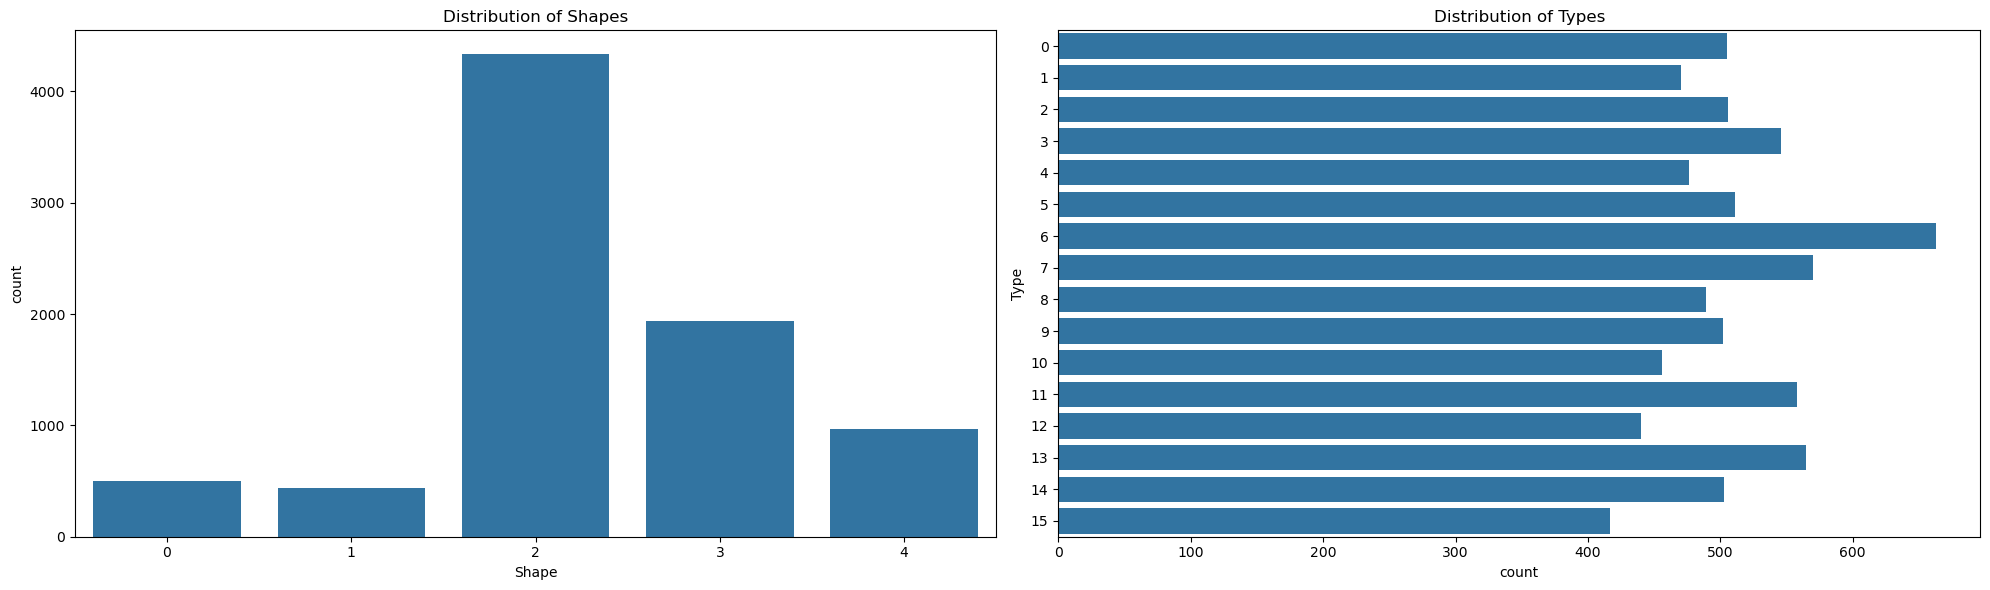

In [29]:
batch_dict_type = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 16, 'hex'],
        'crossing': [2, 7, 'square'],
        'roundabout': [10, 6, 'round'],
        'laneend': [4, 5, 'square'],
        'traveldirection': [14, 5, 'round'],
        'limitedtraffic': [5, 5, 'round'],
        'trafficdirective': [13, 3, 'round'],
        'continue': [1, 2, 'square'],
        'giveway': [3, 2, 'triangle'],
        'noparking': [7, 2, 'round'],
        'parking': [8, 1, 'square'],
        'rightofway': [9, 1, 'diamond'],
        'bicycle': [0, 1, 'round'],
        'speed': [11, 1, 'round'], 
        'noentry': [6, 1, 'round'],
    }
train_type_augmented = start_shape_augmentation(train, 'Type', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/type_aug/train', 
                                           batch_dict=batch_dict_type)

In [30]:
def calc_class_weights(df, label):
    unique_labels = train[label].unique()
    weights =  compute_class_weight(class_weight="balanced", classes=df[label].unique(), y=df[label].to_numpy())
    class_weights = dict(zip(unique_labels, weights))
    return class_weights

Generate Images for Training

In [31]:
def create_image_batches(df, batch_size, label, target_size=(28, 28), is_train = True):
        df[label] = df[label].astype('str')
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

        if is_train:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        color_mode="grayscale",
                        class_mode='categorical')
        else:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        shuffle=False,
                        color_mode="grayscale",
                        class_mode='categorical'
                        )
        
        return train_generator

In [32]:
# create image batches from train for Shape
shape_train_generator = create_image_batches(df=train, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_val_generator = create_image_batches(df=val, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_test_generator = create_image_batches(df=test, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Shape
shape_aug_train_generator = create_image_batches(df=train_shape_aug, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 4626 validated image filenames belonging to 5 classes.


In [33]:
type_train_generator = create_image_batches(df=train, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_val_generator = create_image_batches(df=val, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_test_generator = create_image_batches(df=test, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Type
type_aug_train_generator = create_image_batches(df=train_type_augmented, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.
Found 750 validated image filenames belonging to 16 classes.
Found 8177 validated image filenames belonging to 16 classes.


Model Development

In [34]:
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28, 28, 1)
# define metrics
METRIC = tf.keras.metrics.AUC(curve='PR', name='PR', from_logits=True)
LOSS_METRIC = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


print(
    f"Classes_Shape: {OUTPUT_CLASSES_SHAPE}\n"
    f"Classes_Type: {OUTPUT_CLASSES_TYPE}\n"
    f"Metric: {METRIC}\n"
    f"Loss Metric: {LOSS_METRIC}\n"
)

Classes_Shape: 5
Classes_Type: 16
Metric: <AUC name=PR>
Loss Metric: <keras.src.losses.losses.CategoricalCrossentropy object at 0x281d18850>



2024-05-19 18:50:31.756948: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-19 18:50:31.757105: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-19 18:50:31.757127: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-19 18:50:31.757165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 18:50:31.757278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [36]:
def plot_performance(history, metric_label):
    val_metric_label = 'val_' + metric_label
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history[metric_label], history.history[val_metric_label], 
                    metric_name = metric_label)

In [37]:
def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    plot_performance(history=history, metric_label='PR')
    return model

Fetch class weights

In [38]:
shape_weights = calc_class_weights(df=train, label='Shape')
shape_weights

{'0': 2.620118343195266,
 '1': 17.712,
 '3': 1.0773722627737226,
 '4': 0.7978378378378378,
 '2': 0.42011385199240986}

In [39]:
type_weights = calc_class_weights(df=train, label='Type')
type_weights

{'9': 0.8187869822485208,
 '12': 5.535,
 '4': 1.9767857142857144,
 '8': 0.8386363636363636,
 '1': 1.1628151260504203,
 '2': 2.4276315789473686,
 '3': 1.002717391304348,
 '15': 0.3318345323741007,
 '14': 1.8699324324324325,
 '5': 1.845,
 '11': 0.7321428571428571,
 '10': 2.3857758620689653,
 '6': 0.615,
 '7': 0.9543103448275863,
 '0': 0.8092105263157895,
 '13': 1.1826923076923077}

### Models

Base MLP

In [59]:
def baseline_mlp(output_class):

        HIDDEN_LAYER_DIM = 200
        OUTPUT_CLASSES = output_class
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE

        model = tf.keras.Sequential([
        
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
        ])

        model.summary()

        return model


Base VGG

In [41]:
def build_model_VGG(input_shape, output_classes, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
   
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(output_classes, activation='softmax'),
    ])

    return model

Tuneable VGG with L2 Regularization

In [42]:
def build_model_VGG_reg_shape(hp):    
    lambda_value = hp.Choice('lambda', [0.006407366308178109, 0.018037870215070927, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [43]:
def build_model_VGG_reg_type(hp):    
    lambda_value = hp.Choice('lambda', [0.1, 0.01, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

Tunable VGG with Dropout Regularization

In [44]:
def build_model_VGG_dropout_shape(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.018037870215070927
    else:
        lambda_value = 0.006407366308178109

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [45]:
def build_model_VGG_dropout_type(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.001
    else:
        lambda_value = 0.0001

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

### Tuners

Lambda Tuner

In [46]:
# Initialize the l2 tuner
def init_lambda_tuner(choice):
    if (os.path.exists('lambda_tuning')):
        shutil.rmtree(r'./lambda_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_reg_shape
    else:
        model_builder = build_model_VGG_reg_type

    lambda_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=3,
        project_name='lambda_tuning')
    return lambda_tuner

Dropout Tuner

In [47]:
# Initialize the droput tuner
def init_dropout_tuner(choice):
    if (os.path.exists('dropout_tuning')):
        shutil.rmtree(r'./dropout_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_dropout_shape
    else:
        model_builder = build_model_VGG_dropout_type
    
    dropout_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=4,
        project_name='dropout_tuning')
    return dropout_tuner

In [60]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# def compile_model(model, optimiser='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
#     model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
#     return model

In [61]:
def compile_model(model, optimiser='sgd', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=METRICS):
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    return model

In [62]:
def train_model(model, train_generator, val_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight=class_weights, verbose=0)
    return history

In [63]:
def plot_cm(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print('Confusion Matrix:')
    print(cm)

In [64]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(12, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:

def evaluation(model, val_data,output_classes, history):
    evaluation_results = model.evaluate(val_data)
    for name, value in zip(model.metrics_names, evaluation_results):
        print(f"{name}: {value:.4f}")
    
    # Store evaluation results in a DataFrame
    metrics_dict = {name: value for name, value in zip(model.metrics_names, evaluation_results)}
    metrics_df = pd.DataFrame([metrics_dict])

    # Get the true labels and predictions for the validation set
    val_steps = len(val_data)
    val_labels = val_data.classes
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes= output_classes)

    predictions = model.predict(val_data, steps=val_steps)
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot confusion matrix
    plot_cm(np.argmax(val_labels, axis=1), predicted_classes)

    # Plot metrics
    plot_metrics(history=history)

In [ ]:
# def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights, output_classes):
#     model = build_model_VGG(input_shape=INPUT_DIM, output_classes=output_classes, activation=activation)
#     model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
#     history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
#     plot_performance(history=history, metric_label=metric_label)
#     return model


In [77]:
def pipeline(model_fn, output_classes, train, val, metric, optimiser, activation, epoch, class_weights):
    model = model_fn
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=metric)
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    evaluation(model, val,output_classes, history)
    # plot_performance(history=history, metric_label=metric_label)
    return model


Baseline Model

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,005 (617.21 KB)

 Trainable params: 158,005 (617.21 KB)

 Non-trainable params: 0 (0.00 B)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - Brier score: 111.6613 - accuracy: 0.9087 - auc: 0.9515 - cross entropy: 1.1651 - fn: 4.5000 - fp: 170.9583 - loss: 0.0932 - prc: 0.7391 - precision: 0.6900 - recall: 0.9879 - tn: 1423.3750 - tp: 394.0833
loss: 0.0785
compile_metrics: 1.0719
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


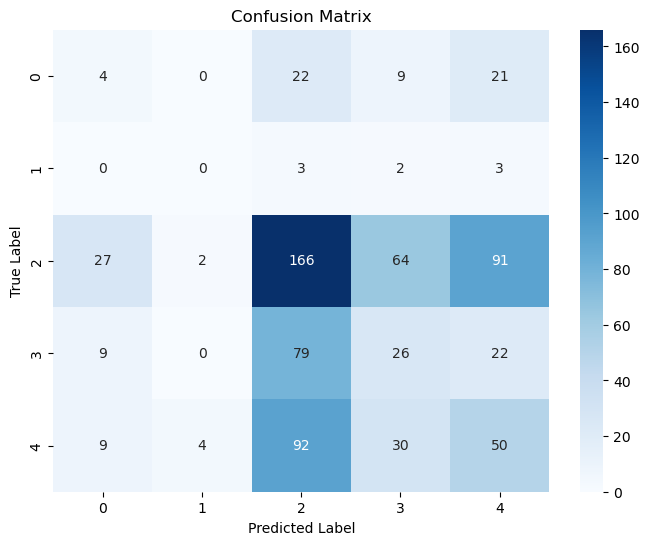

Confusion Matrix:
[[  4   0  22   9  21]
 [  0   0   3   2   3]
 [ 27   2 166  64  91]
 [  9   0  79  26  22]
 [  9   4  92  30  50]]


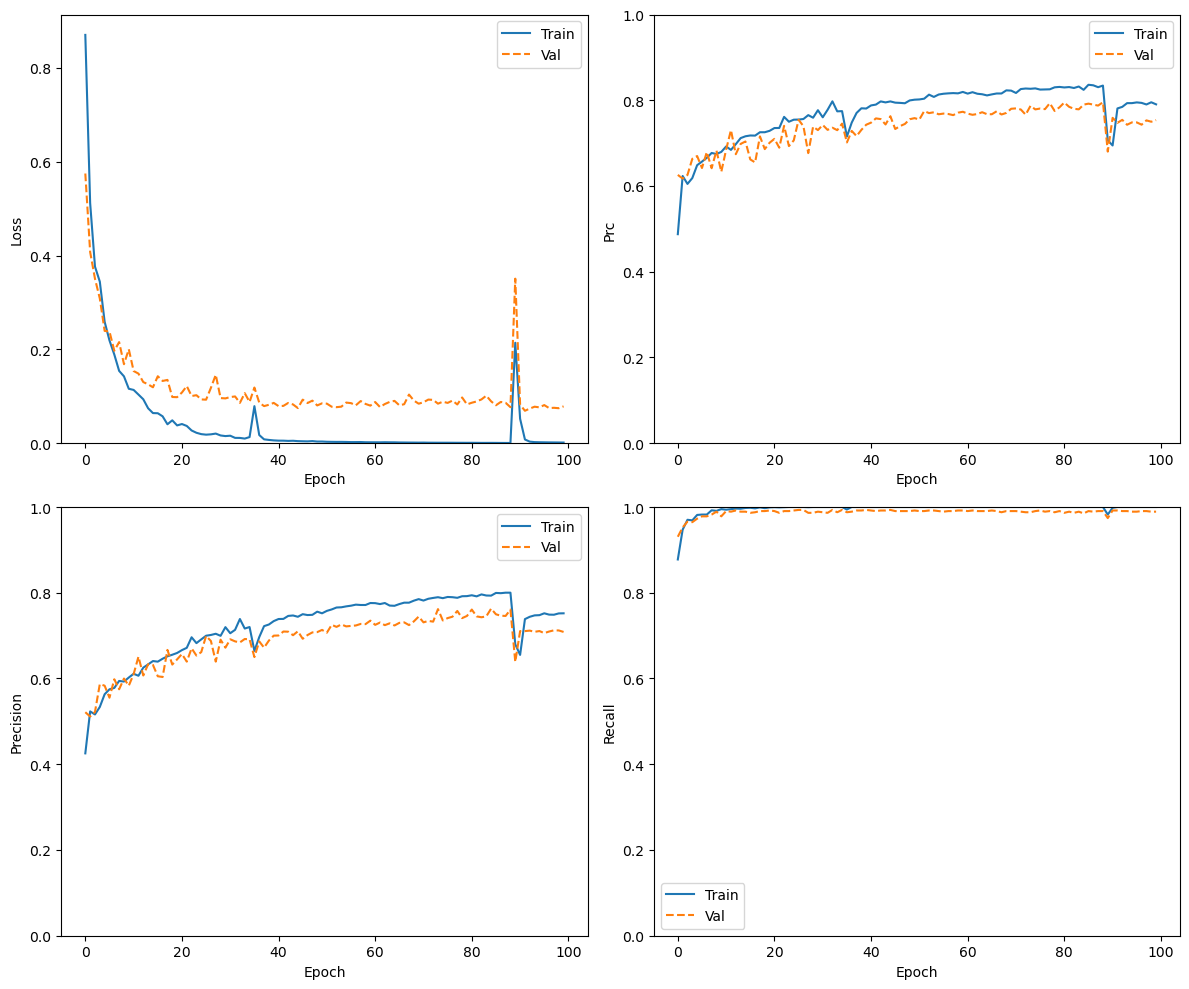

In [72]:
baseline_mlp_model_shape = pipeline(baseline_mlp(5),5,
                              shape_train_generator, 
                              shape_val_generator, 
                              metric =METRICS,
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [80]:
baseline_mlp_model_shape.save('models/shape/mbaseline_mlp_model_shape.keras')

Convolutional Neural Network (CNN)

VGG with Adam Optimiser

In [ ]:
# model_VGG_base_adam_shape = pipeline(shape_train_generator, 
#                           shape_val_generator, 
#                           metric_label='PR',
#                           optimiser='adam',
#                           activation='relu',
#                           epoch=100,
#                           output_classes=OUTPUT_CLASSES_SHAPE,
#                           class_weights=None)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - Brier score: 0.0020 - accuracy: 0.9975 - auc: 0.9998 - cross entropy: 0.8266 - fn: 2.5000 - fp: 2.5000 - loss: 0.0228 - prc: 0.9995 - precision: 0.9937 - recall: 0.9937 - tn: 1591.8334 - tp: 396.0833  
loss: 0.0352
compile_metrics: 0.8513
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


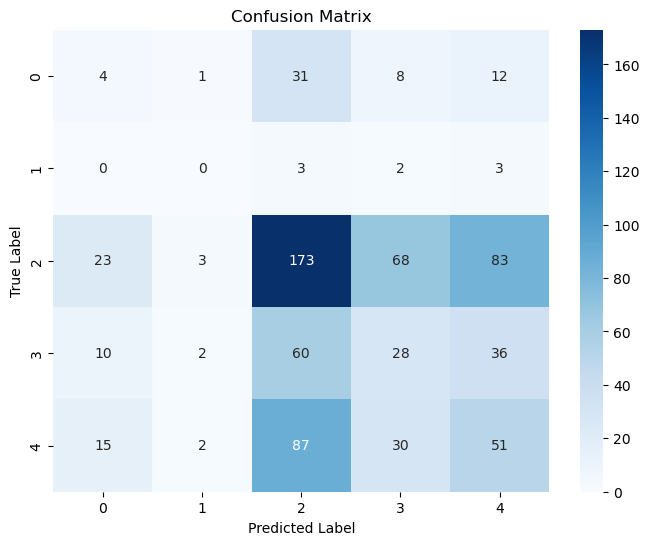

Confusion Matrix:
[[  4   1  31   8  12]
 [  0   0   3   2   3]
 [ 23   3 173  68  83]
 [ 10   2  60  28  36]
 [ 15   2  87  30  51]]


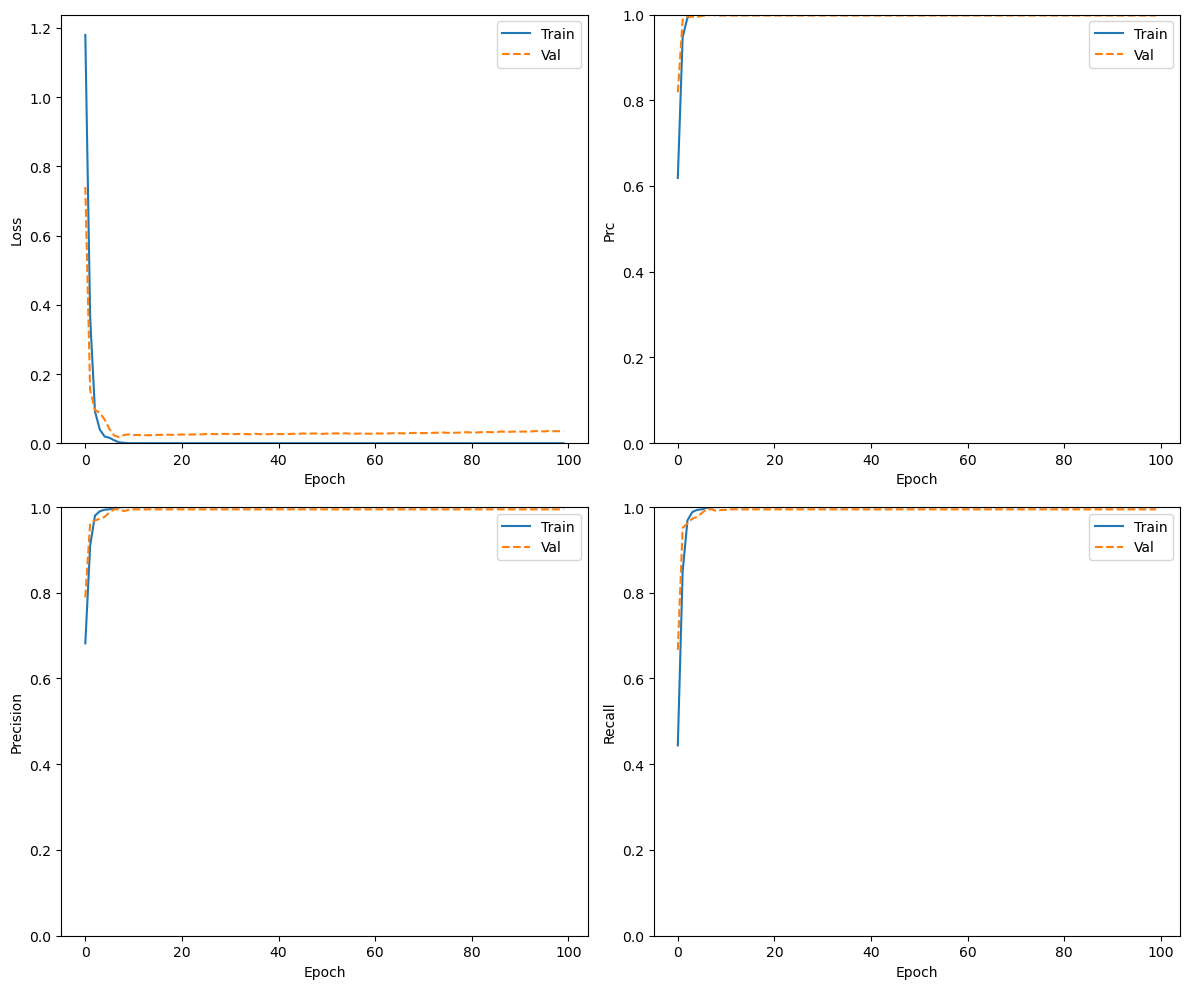

In [79]:
model_VGG_base_adam_shape = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'), 5, 
                                shape_train_generator, 
                                shape_val_generator, 
                                metric =METRICS,
                                optimiser='adam',
                                activation='relu',
                                epoch=100,
                                class_weights=None)

In [81]:
model_VGG_base_adam_shape.save('models/shape/model_VGG_base_adam_shape.keras')

VGG with SGD Optimiser

In [ ]:
# model_VGG_base_SGD_shape = pipeline(shape_train_generator, 
#                           shape_val_generator, 
#                           metric_label='PR',
#                           optimiser='sgd',
#                           activation='relu',
#                           epoch=100,
#                           output_classes=OUTPUT_CLASSES_SHAPE, 
#                           class_weights=None)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Brier score: 0.0071 - accuracy: 0.9919 - auc: 0.9990 - cross entropy: 2.4933 - fn: 8.1250 - fp: 6.9167 - loss: 0.0764 - prc: 0.9971 - precision: 0.9809 - recall: 0.9786 - tn: 1587.4166 - tp: 390.4583
loss: 0.0994
compile_metrics: 2.4532
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


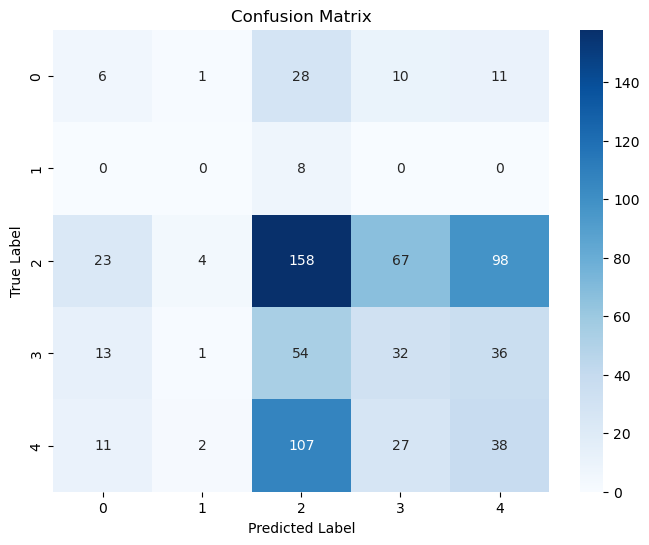

Confusion Matrix:
[[  6   1  28  10  11]
 [  0   0   8   0   0]
 [ 23   4 158  67  98]
 [ 13   1  54  32  36]
 [ 11   2 107  27  38]]


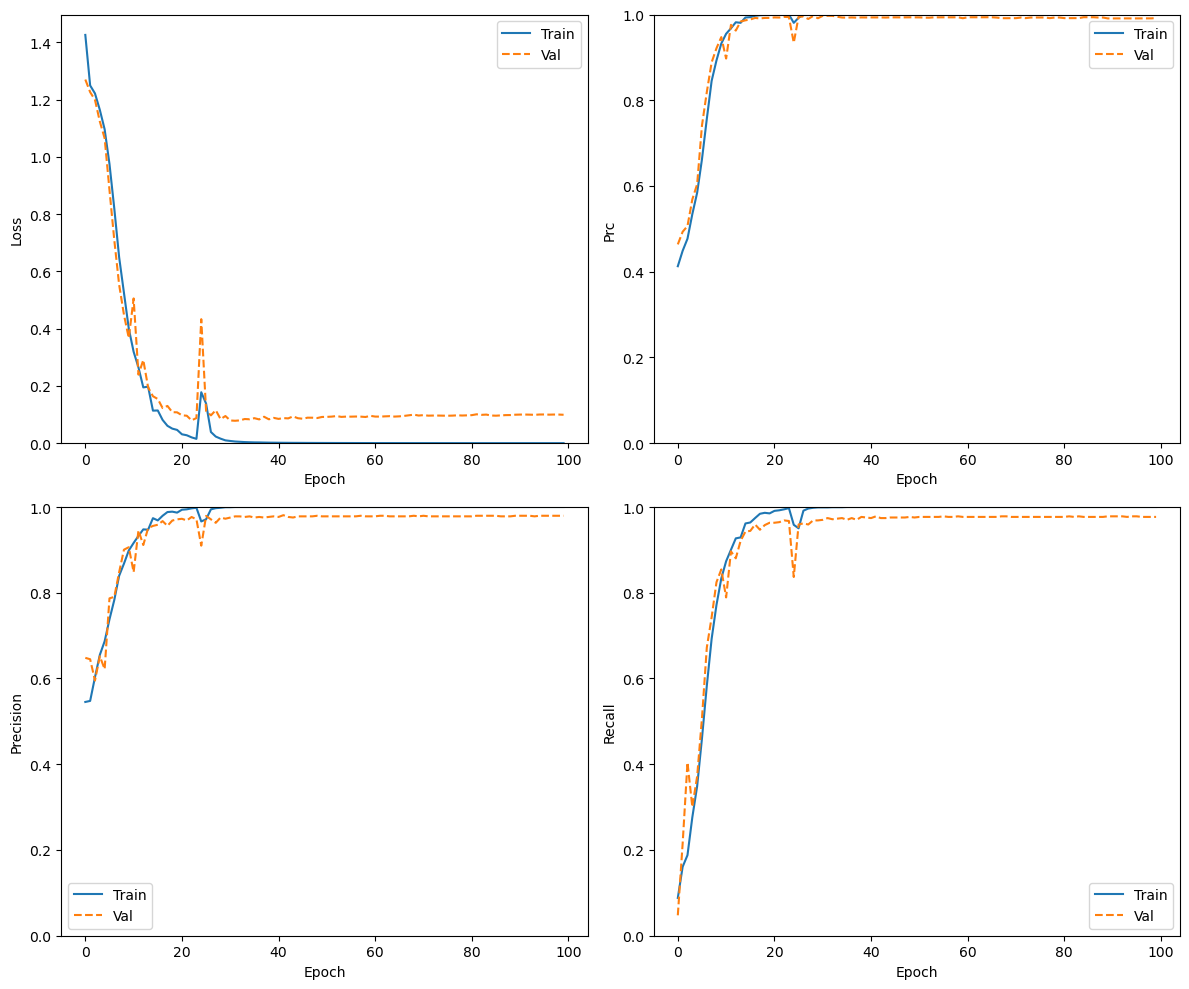

In [83]:
model_VGG_base_SGD_shape = pipeline(build_model_VGG(input_shape=INPUT_DIM,output_classes=5, activation='relu'), 5, 
                                shape_train_generator, 
                                shape_val_generator, 
                                metric =METRICS,
                                optimiser='sgd',
                                activation='relu',
                                epoch=100,
                                class_weights=None)

In [ ]:
model_VGG_base_SGD_shape.save('models/shape/model_VGG_base_SGD_shape.keras')

Class Re-Weighting

VGG with Class Re-Weighting

In [ ]:
model_VGG_base_SGD_shape_reweighted = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE,
                          class_weights=shape_weights)

In [ ]:
model_VGG_base_SGD_shape_reweighted.save('models/shape/model_VGG_base_SGD_shape_reweighted.keras')

L2 Regularisation

In [ ]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape = tune_model(lambda_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [ ]:
best_model_l2_shape.save('models/shape/best_model_l2_shape.keras')

Dropout Regularisation

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_droput_shape = tune_model(dropout_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [ ]:
best_model_droput_shape.save('models/shape/best_model_droput_shape.keras')

Augmented Data

In [ ]:
augmented = True

In [ ]:
model_VGG_base_SGD_shape_aug = pipeline(shape_aug_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [ ]:
model_VGG_base_SGD_shape_aug.save('models/shape/model_VGG_base_SGD_shape_aug.keras')

Regularisation

In [ ]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape_aug = tune_model(lambda_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [ ]:
best_model_l2_shape_aug.save('models/shape/best_model_l2_shape_aug.keras')

Dropout

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_dropout_shape_aug = tune_model(dropout_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [ ]:
best_model_dropout_shape_aug.save('models/shape/best_model_droput_shape_aug.keras')

Type

In [ ]:
augmented = False

Base SGD Optimiser

In [ ]:
model_VGG_base_SGD_type = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [ ]:
model_VGG_base_SGD_type.save('models/type/model_VGG_base_SGD_type.keras')

Reweighted SGD Optimiser

In [ ]:
model_VGG_base_SGD_type_reweighted = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=type_weights)

In [ ]:
model_VGG_base_SGD_type_reweighted.save('models/type/model_VGG_base_SGD_type_reweighted.keras')

L2 Regularisation

In [ ]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type = tune_model(lambda_tuner, type_train_generator, type_val_generator, type_weights, 100, 'lambda')

In [ ]:
best_model_l2_type.save('models/type/best_model_l2_type.keras')

Dropout Regularisation

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type = tune_model(dropout_tuner, type_train_generator, type_val_generator, type_weights, 100, 'dropout_rate')

In [ ]:
best_model_droput_type.save('models/type/best_model_droput_type.keras')

Augmented Data

In [ ]:
augmented = True

In [ ]:
model_VGG_base_SGD_type_aug = pipeline(type_aug_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [ ]:
model_VGG_base_SGD_type_aug.save('models/type/model_VGG_base_SGD_type_aug.keras')

L2 Regularisation

In [ ]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type_aug = tune_model(lambda_tuner, type_aug_train_generator, type_val_generator, None, 100, 'lambda')

In [ ]:
best_model_l2_type_aug.save('models/type/best_model_l2_type_aug.keras')

Dropout Regularisation

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type_aug = tune_model(dropout_tuner, type_aug_train_generator, type_val_generator, None, 100, 'dropout_rate')

In [ ]:
best_model_droput_type_aug.save('models/type/best_model_droput_type_aug.keras')

### Testing